In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_json("./data/scans.json",lines = True)

## Wie sehen die Daten aus?

In [3]:
df

,scanTimestamp,locationId,userId,scanMinutes,indexCase
0,1618221536,a8f303e723297b4,x1cad2ea574d0e291,64,False
1,1618244176,x6ba61b42d5c4e641,7f8aeb9aaac301a1,91,False
2,1618235530,35b0e22fa29673e7,x2f0c35058f3505e9,69,False
3,1618221097,381fbbe5bea1f6ec,x20c464aeffa23142,62,False
4,1618236175,x1b85abcc497d0df3,3c72b592c9840ee8,82,False
...,...,...,...,...,...
13950,1618222318,x1367508230579fd1,f22a16895832d1d,91,False
13951,1618230454,1ddade21b1760622,x1fd0475c2c92e822,97,False
13952,1618229503,1c8f2823649d3ee4,x221ce60441f7391,84,False
13953,1618244663,4258e690ea55a16e,x5f105ba78c374ccc,102,False


In [4]:
df.duplicated().nunique()

1

Es gibt keine doppelten Datensätze

# Die Aufgabenstellung

Finde alle Kontaktpersonen ("userId") einer infizierten Person
("indexCase": true), die sich zur selben Zeit im selben Raum
("locationId") aufhielten, und berechne anhand von Scan-Zeitpunkten
("scanTimestamp") und Scan-Dauer ("scanMinutes") für diese Personen die
Gesamtkontaktdauer zum Infizierten. Welche Personen haben ein hohes
Risiko, sich mit Corona angesteckt zu haben?

# Die Variablen

### scanTimestamp

Unix TimeStamp wann der Eintritt in die location stattfand

### locationId

OrtID

### userId

ID des Nutzers

### scanMinutes

Dauer in Minuten zwischen Eintritt (scanTimestamp) bis zum Verlassen der location

### indexCase

Corona-infiziert?

# Finde alle gefährdeten Personen

+ Finde alle Personen die eine Zeitüberschneidung mit den infizierten Personen haben am selben Ort
+ Gruppiere die risikogefährdeten Personen nach Zeitbins in unterschiedliche Gruppen

### Datenset umbauen mit klarem Zeitintervall auf dem Zahlenstrahl

In [5]:
df.rename(columns={"scanTimestamp": "enter"},inplace=True)

In [6]:
df["scanSecs"] =  df.scanMinutes*60
df["leave"] = df.enter + df.scanSecs
df["date"] = df.enter.apply(lambda x: pd.Timestamp(x, unit = "s").date())
df["date"] = pd.to_datetime(df["date"])

In [7]:
df

,enter,locationId,userId,scanMinutes,indexCase,scanSecs,leave,date
0,1618221536,a8f303e723297b4,x1cad2ea574d0e291,64,False,3840,1618225376,2021-04-12
1,1618244176,x6ba61b42d5c4e641,7f8aeb9aaac301a1,91,False,5460,1618249636,2021-04-12
2,1618235530,35b0e22fa29673e7,x2f0c35058f3505e9,69,False,4140,1618239670,2021-04-12
3,1618221097,381fbbe5bea1f6ec,x20c464aeffa23142,62,False,3720,1618224817,2021-04-12
4,1618236175,x1b85abcc497d0df3,3c72b592c9840ee8,82,False,4920,1618241095,2021-04-12
...,...,...,...,...,...,...,...,...
13950,1618222318,x1367508230579fd1,f22a16895832d1d,91,False,5460,1618227778,2021-04-12
13951,1618230454,1ddade21b1760622,x1fd0475c2c92e822,97,False,5820,1618236274,2021-04-12
13952,1618229503,1c8f2823649d3ee4,x221ce60441f7391,84,False,5040,1618234543,2021-04-12
13953,1618244663,4258e690ea55a16e,x5f105ba78c374ccc,102,False,6120,1618250783,2021-04-12


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13955 entries, 0 to 13954
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   enter        13955 non-null  int64         
 1   locationId   13955 non-null  object        
 2   userId       13955 non-null  object        
 3   scanMinutes  13955 non-null  int64         
 4   indexCase    13955 non-null  bool          
 5   scanSecs     13955 non-null  int64         
 6   leave        13955 non-null  int64         
 7   date         13955 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(2)
memory usage: 776.9+ KB


In [9]:
df.nunique()

enter           8687
locationId       175
userId          4020
scanMinutes       52
indexCase          2
scanSecs          52
leave          10871
date               1
dtype: int64

### Subfazit

Es gibt 4020 unterschiedliche Personen und 175 unterschiedliche Orte. Der gesamte Datensatz betrachtet nur einen einzigen Tag, den 2021-04-12. 

Der Datensatz hat eine Größe von 13955 Beobachtungen, d. h. dass es 13955 Registrierungen einer Person an einem Ort gab.

In [10]:
date = df.date[0].date()
date

datetime.date(2021, 4, 12)

### Alle infizierten Personen: df_sick

In [11]:
df_sick = df[df["indexCase"] == True]

In [12]:
df_sick

,enter,locationId,userId,scanMinutes,indexCase,scanSecs,leave,date
2275,1618237658,x28d7ad68647cfd8f,x1d2f457ffccd37c6,94,True,5640,1618243298,2021-04-12
3798,1618221985,x28d7ad68647cfd8f,x1d2f457ffccd37c6,92,True,5520,1618227505,2021-04-12
9402,1618229117,x50444ff334d4b9af,x1d2f457ffccd37c6,95,True,5700,1618234817,2021-04-12
11049,1618251864,x50444ff334d4b9af,x1d2f457ffccd37c6,94,True,5640,1618257504,2021-04-12
12994,1618242930,x33e8e9d0b59c661,x1d2f457ffccd37c6,60,True,3600,1618246530,2021-04-12


In [13]:
df_sick.nunique()

enter          5
locationId     3
userId         1
scanMinutes    4
indexCase      1
scanSecs       4
leave          5
date           1
dtype: int64

### Subfazit

Es gibt im gesamten Datensatz nur eine Person mit Corona. Diese Person war in 5 unterschiedlichen locactions.

## Überlegung

+ sickPerson: Person mit Corona
+ riskPerson: Person mit potentieller Chance Corona durch Kontakt zu bekommen

#### Idee

Damit eine zeitliche Überschneidung stattfindet muss entweder
+ die riskPerson im Zeitintervall der Anwesenheit der sickPerson die location betreten
+ oder im Zeitintervall der Anwesenheit der sickPerson die location verlassen.

In [14]:
df_riskpeople = pd.DataFrame()

df0 = df[df["indexCase"] == False]

for enter, leave, locationId in zip(df_sick.enter, df_sick.leave, df_sick.locationId):
    #riskperson kommt im Riskinterval
    #riskperson geht im Riskinterval
    
    df_part = df0[((df0["enter"]>= enter) | (df0["leave"]<= leave)) & (df0["locationId"] == locationId)]
    #df_part = df0[(df0["locationId"] == locationId )]
    
    df_riskpeople = pd.concat([df_riskpeople, df_part], axis=0)

In [15]:
df_riskpeople.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350 entries, 44 to 13817
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   enter        350 non-null    int64         
 1   locationId   350 non-null    object        
 2   userId       350 non-null    object        
 3   scanMinutes  350 non-null    int64         
 4   indexCase    350 non-null    bool          
 5   scanSecs     350 non-null    int64         
 6   leave        350 non-null    int64         
 7   date         350 non-null    datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(2)
memory usage: 22.2+ KB


In [16]:
df_riskpeople.nunique()

enter          198
locationId       3
userId          74
scanMinutes     51
indexCase        1
scanSecs        51
leave          199
date             1
dtype: int64

In [17]:
df_riskpeople

,enter,locationId,userId,scanMinutes,indexCase,scanSecs,leave,date
44,1618214506,x28d7ad68647cfd8f,1b70a4f6b1a2cc77,93,False,5580,1618220086,2021-04-12
150,1618243503,x28d7ad68647cfd8f,6315f8ce44ffb576,97,False,5820,1618249323,2021-04-12
253,1618251514,x28d7ad68647cfd8f,6a42ebcd40e1215,84,False,5040,1618256554,2021-04-12
381,1618243383,x28d7ad68647cfd8f,x3d61515a1942a2e8,67,False,4020,1618247403,2021-04-12
469,1618236397,x28d7ad68647cfd8f,x61c3b41a955d1cb9,104,False,6240,1618242637,2021-04-12
...,...,...,...,...,...,...,...,...
13298,1618244197,x33e8e9d0b59c661,383216286a6d24ed,81,False,4860,1618249057,2021-04-12
13416,1618229188,x33e8e9d0b59c661,x5ddb1649abf2159b,69,False,4140,1618233328,2021-04-12
13527,1618251752,x33e8e9d0b59c661,x15a4b54d998d8463,86,False,5160,1618256912,2021-04-12
13670,1618243743,x33e8e9d0b59c661,30723b215852be59,67,False,4020,1618247763,2021-04-12


### Subfazit

Mit der infizierten Person gibt es 350 zeitliche Überschneidungen von insgesamt 74 unterschiedlichen Personen.

# Ausgabeformat

Im Sinne des Datenschutzes nehme ich an, dass nur wichtig ist zu wissen ob eine Person gefährdet ist oder nicht. Um Quarantänemaßnahmen zu planen oder anderweitiges wohl auch das Datum. Beim Ort kann man eventuell zu gute Rückschlüsse ziehen, wer die infizierte Person ist. 

Aber im Sinne der Auswertung werde ich für jede Person userId, alle locationId das date und contact_num (Anzahl der Kontakte) ausgeben.

In [18]:
df_output = pd.DataFrame(data = df_riskpeople["userId"].unique(), columns=["userId"])

tmp = df_riskpeople.groupby(['userId'])['locationId'].unique().to_dict()
df_output['locations'] = df_output['userId'].map(tmp)
df_output["contact_num"] = df_output["locations"].apply(lambda x: len(x))
df_output["contact_num"] = df_output["contact_num"].astype(int)
df_output["date"] = [date for _ in range(len(df_output))]
#df_output["date"] = pd.to_datetime(df_output["date"])
df_output.set_index("userId", inplace=True)
df_output

,locations,contact_num,date
userId,,,
1b70a4f6b1a2cc77,[x28d7ad68647cfd8f],1,2021-04-12
6315f8ce44ffb576,[x28d7ad68647cfd8f],1,2021-04-12
6a42ebcd40e1215,[x28d7ad68647cfd8f],1,2021-04-12
x3d61515a1942a2e8,[x28d7ad68647cfd8f],1,2021-04-12
x61c3b41a955d1cb9,"[x28d7ad68647cfd8f, x50444ff334d4b9af]",2,2021-04-12
...,...,...,...
x192622e2c2ad576e,[x33e8e9d0b59c661],1,2021-04-12
x1f8f33aa2ae25eb1,[x33e8e9d0b59c661],1,2021-04-12
x2493f06df9211cb4,[x33e8e9d0b59c661],1,2021-04-12


In [19]:
df_output.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 1b70a4f6b1a2cc77 to x15a4b54d998d8463
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   locations    74 non-null     object
 1   contact_num  74 non-null     int64 
 2   date         74 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.3+ KB


Text(0.5, 1.0, 'Number of contacts with infected person')

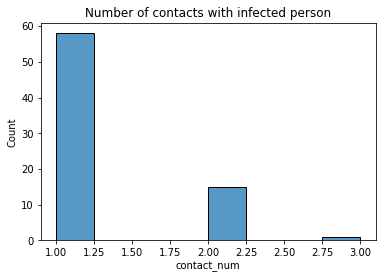

In [20]:
ax = sns.histplot(data = df_output,x = "contact_num")
ax.set_title("Number of contacts with infected person")

Man kann ganz schön erkennen, dass die meisten Personen mit einem Kontakt nur einen Kontakt hatten. Sehr selten sind drei Kontakte. Um aufgrund der Häufigkeit eine Aussage zu treffen, müssten mehr Informationen vorliegen, ob dieses Kriterium in irgend einer Weise zu Buche schlägt. 

Weiterhin ist sicherlich auch interessant die zeitliche Überschneidungsdauer zu betrachten. Soweit meine Erinnerung, ist das Maß von 15 Minuten in großer Nähe bisher als Kriterium für eine hohe Ansteckungswahrscheinlichkeit gehandelt worden. Diese Information habe ich nicht extrahiert und ausgegeben und wäre Teil der weiteren Ausarbeitung.

Für betroffene Menschen sind nach meiner Analyse, ausschließlich begründet auf wenigen Stunden Beschäftigung mit dem Thema hier, Erinnerungen und Nachdenken, wohl 
+ die binäre Aussage (Risiko ja/nein?)
+ Datum der potentiellen Ansteckung
+ Gradmesser für die Wahrscheinlichkeit einer Ansteckung bei Kontakt (begründet auf Dauer, Anzahl Kontakte...)


## Speichern als .json

In [21]:
df_output.to_json("./data/riskPeople.json", orient="values")

# Ausblick

Mit meiner Idee nutze ich die pandas Bibliothek von python, so wie ich es gelernt habe im DataScience Kurs. Hierbei werden alle Daten in den Arbeitsspeicher geladen. Ich kann mir vorstellen, dass mein Verfahren nicht geeignet ist für große Datenmengen.

Mein anfängliches Ziel war die Überführung der Infektionsgefahr in einen Zeitstrahlvektor (errechnet aus allen Orten und Zeitintervallen der infizierten Personen) und einen locationVector entsprechend des Zeitstrahlvektors kodiert, um danach für die Auswertung durch ein einfaches inneres Produkt auszuwerten ob eine Person gefährdet ist oder nicht. Der Zeitstrahlvektor hätte nur Werte zwischen 0 und 1 enthalten (keine Ansteckungsgefahr, Ansteckungsgefahr). Der locationVektor hätte auch nur 0 und 1 enthalten (zur Zeit NICHT am Ort, zur Zeit SCHON am Ort). Ort wäre die Liste aller gefährdeten Orte gewesen. 

Die Gefahr ist ein sehr langer Zeitstrahlvektor bei vielen Infizierten und dadurch eine sehr große Segmentation und Rechenzeit. Bei wenigen infizierten wäre das Verfahren sehr schnell, da der Zeitstrahlvektor nur aufgrund der infizierten Personen errechnet wird und dann die Kodierung der Zeitesquenz klar wäre. Nun könnte nacheinander jede zu evaluierende gefährete Person geladen werden, deren locationVektor erstellt werden und über das innere Produkt eine errechnete Lösung getroffen werden. Alternativ kann aber auch einfach hier durch Fallunterscheidung das Ziel erreicht werden. 

Die Idee ist in keinster Weise ausgereift. Da es darum geht zu sehen wie ich analytisch mit dem meinem begrenzten Programmierwissen umgehe, wollte ich über meine sehr einfache Lösung hinaus noch etwas vorschlagen. 

Die Motivation ist ein Verfahren, dass durch MatrixMultiplikation zu einem binären Ergebnis kommt (die Suche nach einer Nicht-Datenbanksuch-Lösung) und Daten nacheinander laden kann.
